In [13]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

from fastai.vision.all import vision_learner, resnet18, BalancedAccuracy, DataLoaders

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'seed': 42,
    'batch_size': 32
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')

# Functions
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Seed
seed_everything(CFG['seed'])
torch.backends.cudnn.benchmark = True

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))

# Label encoder/decoder
encode = {v: k for k, v in enumerate(df.label.unique())}
decode = {v: k for k, v in encode.items()}

In [2]:
class UBCDataset(Dataset):
    """UBC OCEAN dataset."""

    def __init__(self, csv_path, image_dir, thumbnail_dir, encode, transform=None):
        """
        Arguments:
            csv_path (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the fullres images.
            thumbnail_dir (string): Directory with all the thumbnail images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_path)
        self.df['label'] = self.df['label'].map(encode)
        self.image_ids = self.df['image_id'].values
        self.labels = self.df['label'].values
        self.image_dir = image_dir
        self.thumbnail_dir = thumbnail_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.thumbnail_dir, f'{image_id}_thumbnail.png')
        if not os.path.exists(image_path):
            image_path = os.path.join(self.image_dir, f'{image_id}.png')

        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(image_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label}

        return sample
    
class SideCrop(nn.Module):
    def forward(self, image):
        size = min(image.size)
        new_image = transforms.functional.crop(image, 0, 0, size, size)
        return new_image
        
transforms = {
    'train':
    transforms.Compose([
        SideCrop(),
        transforms.Resize((512, 512)),
        # transforms.RandomAffine(10, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation':
     transforms.Compose([
        SideCrop(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

train_dataset = UBCDataset(csv_path=os.path.join(data_dir, train_csv), 
                     image_dir=train_image_dir, 
                     thumbnail_dir=train_thumbnail_dir,
                     encode=encode,
                     transform=transforms['train'])
validation_dataset = UBCDataset(csv_path=os.path.join(data_dir, train_csv), 
                     image_dir=train_image_dir, 
                     thumbnail_dir=train_thumbnail_dir,
                     encode=encode,
                     transform=transforms['validation'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True, sampler=)
test_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True, sampler=)
# datasets = {'train': train_dataset, 'validation': validation_dataset}
dataloaders = {'train': train_loader, 'validation': test_loader}

In [15]:
model = models.resnet50(weights='DEFAULT').to(device)

for param in model.parameters():
    param.requires_grad = False 

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/latlab/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.4MB/s]


In [3]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

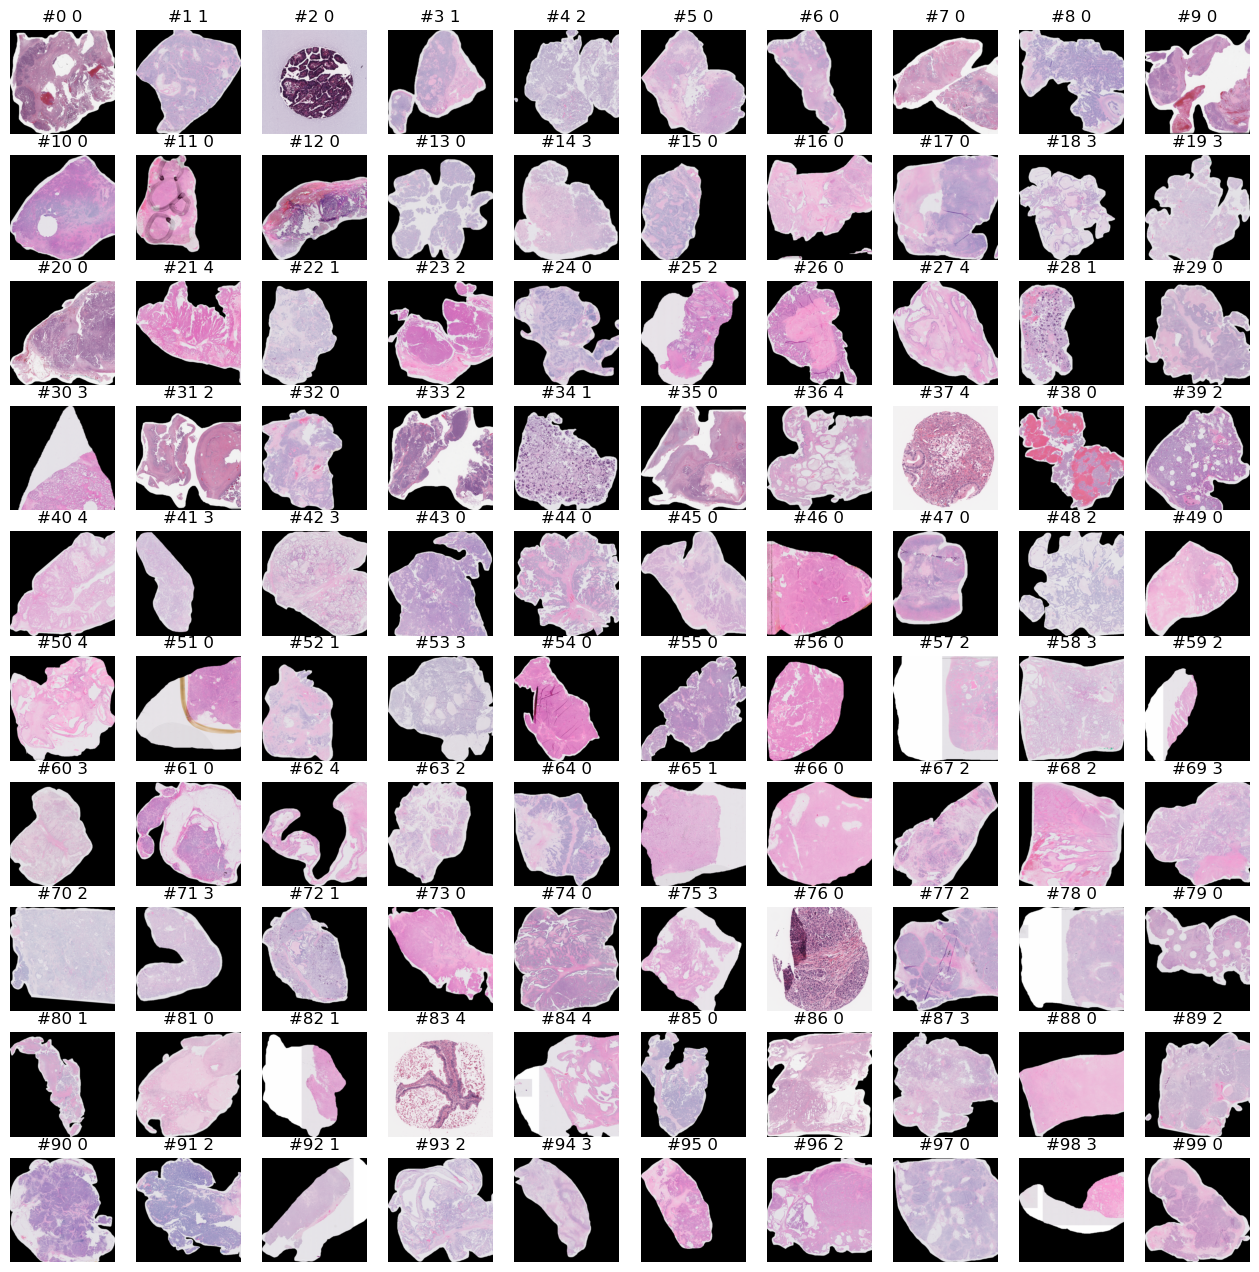

In [5]:
# Plot samples
fig = plt.figure(figsize=(16, 16))
for i, sample in enumerate(dataset):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(sample['image'])
    ax.axis('off')
    plt.title(f"#{i} {sample['label']}")

    if i==99:
        plt.show()
        break